<a href="https://colab.research.google.com/github/usnhee/TIL-/blob/master/filter_visual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras

# dimensions of input image
img_width= 180 
img_height = 180

# target layer: will visualize the filters from this layer
layer_name= 'conv3_block4_out'

# build REsNet50V2 model loaded with pre-trained ImageNet weights
model= keras.applications.ResNet50V2(weights='imagenet', include_top=False)

#set up a model that returns the activation values for target layer 
layer= model.get_layer(name=layer_name)
feature_extractor= keras.Model(inputs=model.inputs, outputs=layer.output)


94683136/94668760 [==============================] - 1s 0us/step


In [4]:
def compute_loss(input_image, filter_index):
  activation=feature_extractor(input_image)
  # avoid border artifacts by only involving non_border pixels in the loss
  filter_activation = activation[:,2:-2,2:-2, filter_index]
  return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss = compute_loss(img, filter_index)
  # compute gradients 
  grads = tape.gradient(loss, img)
  # normalize gradients 
  grads = tf.math.l2_normalize(grads)
  img += learning_rate*grads
  return loss, img

In [11]:
def initialize_image():
  # start from a gray image with some random noise 
  img = tf.random.uniform((1, img_width, img_height, 3))
  # ResNet50V2 expects inputs in the range [-1,+1]
  # Here we scale random inputs to [-0.125,+0.125]
  return (img-0.5)*0.25

def visualize_filter(filter_index):
  # run gradient ascent for 20 steps 
  iterations = 30
  learning_rate=10.0 
  img= initialize_image()
  for iteration in range(iterations):
    loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # decode the resulting input image
    img= deprocess_image(img[0].numpy())
    return loss, img
    

In [10]:
def deprocess_image(img):
  # normalize array : center on 0. , ensure variance is 0.15 
  img -= img.mean()
  img /= img.std() + 1e-5
  img *= 0.15 

  # center crop 
  img = img[25:-25, 25:-25, :]

  # clip to [0,1]
  img += 0.5
  img = np.clip(img, 0, 1)

  # convert to RGB array
  img *= 255
  img = np.clip(img, 0, 255).astype('uint8')
  return img

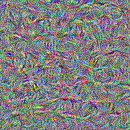

In [12]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img('0.png', img)
display(Image('0.png'))

In [14]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
  print("Processing filter %d" % (filter_index,))
  loss, img = visualize_filter(filter_index)
  all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

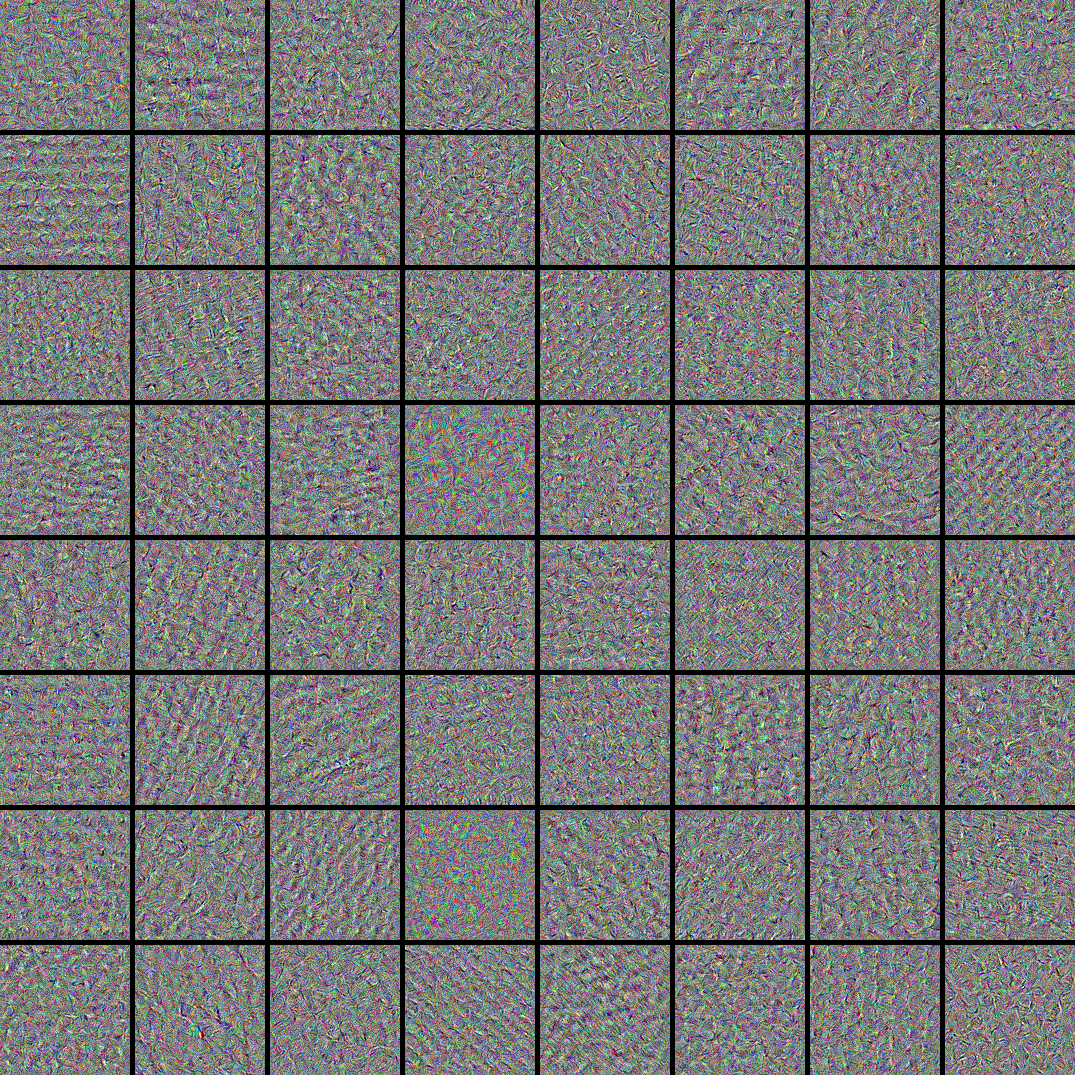

In [15]:
# Fill the picture with our saved filters
for i in range(n):
  for j in range(n):
    img = all_imgs[i * n + j]
    stitched_filters[
      (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,\
      (cropped_height + margin) * j : (cropped_height + margin) * j+ cropped_height,\
      :] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)
from IPython.display import Image, display
display(Image("stiched_filters.png"))